In [9]:
import pandas as pd
import os
import numpy as np
import json

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils

%matplotlib inline
import sklearn.metrics as skl_metrics

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
NLST_PREDS = TEAMS_DIR ## Comment out if not using Teams backup (aka Chansey is up :)

## Handle Sybil annotation info

In [10]:
SYBIL_ANNOT_PATH = f"{TEAMS_DIR}/sybil-nlst-train-annotations.json"
with open(SYBIL_ANNOT_PATH, "r") as f:
    sybil_annots = json.load(f)

sybil_annots

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst/sybil-nlst-train-annotations.json'

In [4]:
sybil_ser_iuids = pd.Series(list(sybil_annots.keys()))
sybil_sop_iuids = pd.Series(sum([list(a.keys()) for a in sybil_annots.values()], start=[]))
len(sybil_ser_iuids), len(sybil_sop_iuids)

(972, 9273)

In [5]:
sybil_sop_iuids.nunique(), sybil_ser_iuids.nunique()

(9273, 972)

In [6]:
sybil_sop_iuids.head()

0    1.2.840.113654.2.55.27516043901205007432317083...
1    1.2.840.113654.2.55.98336108916096429974899588...
2    1.2.840.113654.2.55.28097281540164891590337477...
3    1.2.840.113654.2.55.24791760535415696414038245...
4    1.2.840.113654.2.55.23793008515026704674351422...
dtype: object

In [7]:
sybil_ser_iuids.head()

0    1.2.840.113654.2.55.38995485391900019876570761...
1    1.2.840.113654.2.55.50761756412482430061802871...
2    1.2.840.113654.2.55.24023112856488152536348979...
3    1.2.840.113654.2.55.24785488463405747713776937...
4    1.2.840.113654.2.55.15708941008648745210499888...
dtype: object

In [8]:
nlst_others = pd.read_csv(f"{NLST_PREDS}/nlst_kiran_thijmen_pancan_16077.csv")
kiran_ser_iuids = pd.unique(nlst_others['SeriesInstanceUID'])
kiran_ser_iuids

array(['1.2.840.113654.2.55.240231128564881525363489796879328810792',
       '1.2.840.113654.2.55.50761756412482430061802871163319122196',
       '1.2.840.113654.2.55.125678454609249687113295452275381538966', ...,
       '1.3.6.1.4.1.14519.5.2.1.7009.9004.796552648301224162316340948265',
       '1.3.6.1.4.1.14519.5.2.1.7009.9004.698887010763542043410231186032',
       '1.3.6.1.4.1.14519.5.2.1.7009.9004.513699984521040918361880189881'],
      dtype=object)

In [9]:
match_ser_iuds = set(kiran_ser_iuids).intersection(set(sybil_ser_iuids))

In [10]:
len(match_ser_iuds)

648

## Load Sybil PID to Splits CSV

In [5]:
pidtosplit = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-pid2split.csv")
pidtosplit.head()

,PID,SPLIT
0,122361,test
1,113845,train
2,204631,train
3,126153,train
4,101643,test


In [6]:
pidtosplit['SPLIT'].value_counts(dropna=False)

SPLIT
train    10200
dev       2472
test      2328
Name: count, dtype: int64

In [9]:
import pickle
import re

SYBIL_SERIES_JSON_PATH = f"{NLST_PREDS}/sybil-nlst-pid_tp_series2split.p"

sybil_siuid_dict = pickle.load(open(SYBIL_SERIES_JSON_PATH, "rb"))

ids = list(sybil_siuid_dict.keys())
splits = list(sybil_siuid_dict.values())
pids = [re.split('PID-|__TimePoint-|__Series-', i)[1] for i in ids]
timepoints = [re.split('PID-|__TimePoint-|__Series-', i)[2] for i in ids]
siuids = [re.split('PID-|__TimePoint-|__Series-', i)[3] for i in ids]


sybil_siuid_df = pd.DataFrame({'id': ids, 'split': splits, 'pid': pids, 'timepoint': timepoints, 'SeriesInstanceUID': siuids})
sybil_siuid_df

,id,split,pid,timepoint,SeriesInstanceUID
0,PID-204631__TimePoint-0__Series-1.3.6.1.4.1.14...,train,204631,0,1.3.6.1.4.1.14519.5.2.1.7009.9004.186764828479...
1,PID-204631__TimePoint-1__Series-1.3.6.1.4.1.14...,train,204631,1,1.3.6.1.4.1.14519.5.2.1.7009.9004.154974321095...
2,PID-204631__TimePoint-2__Series-1.3.6.1.4.1.14...,train,204631,2,1.3.6.1.4.1.14519.5.2.1.7009.9004.181632252038...
3,PID-126153__TimePoint-2__Series-1.2.840.113654...,train,126153,2,1.2.840.113654.2.55.43665829455927473870872470...
4,PID-126153__TimePoint-1__Series-1.2.840.113654...,train,126153,1,1.2.840.113654.2.55.18862732764668567267836753...
...,...,...,...,...,...
41275,PID-133831__TimePoint-2__Series-1.2.840.113654...,test,133831,2,1.2.840.113654.2.55.26279217761753193890516762...
41276,PID-133831__TimePoint-0__Series-1.2.840.113654...,test,133831,0,1.2.840.113654.2.55.23986337370551290634823184...
41277,PID-116981__TimePoint-0__Series-1.2.840.113654...,test,116981,0,1.2.840.113654.2.55.16179604920107519147811774...
41278,PID-116981__TimePoint-2__Series-1.2.840.113654...,test,116981,2,1.2.840.113654.2.55.59492406653704762882979549...


In [14]:
sybil_siuid_df.to_csv(f"{NLST_PREDS}/sybil-nlst-splitinfo.csv", index=False)

In [10]:
sybil_siuid_df['split'].value_counts()

split
train    28160
dev       6838
test      6282
Name: count, dtype: int64

In [12]:
sybil_siuid_df.groupby('split').nunique()

,id,pid,timepoint,SeriesInstanceUID
split,,,,
dev,6838,2336,3,6838
test,6282,2203,3,6282
train,28160,9646,3,28160


In [21]:
sybil_siuid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41280 entries, 0 to 41279
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 41280 non-null  object
 1   split              41280 non-null  object
 2   pid                41280 non-null  object
 3   timepoint          41280 non-null  object
 4   SeriesInstanceUID  41280 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


In [66]:
sybil_siuid_df['pid'] = sybil_siuid_df['pid'].astype(int)
sybil_siuid_df['timepoint'] = sybil_siuid_df['timepoint'].astype(int)

In [67]:
sybil_siuid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41280 entries, 0 to 41279
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 41280 non-null  object
 1   split              41280 non-null  object
 2   pid                41280 non-null  int64 
 3   timepoint          41280 non-null  int64 
 4   SeriesInstanceUID  41280 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


### Find intersections between Sybil and Kiran and Tijmen

In [19]:
sybil_train_seriesids = pd.unique(sybil_siuid_df.query('split == "train"')['SeriesInstanceUID'])
sybil_dev_seriesids = pd.unique(sybil_siuid_df.query('split == "dev"')['SeriesInstanceUID'])
sybil_test_seriesids = pd.unique(sybil_siuid_df.query('split == "test"')['SeriesInstanceUID'])
len(sybil_train_seriesids), len(sybil_dev_seriesids), len(sybil_test_seriesids)

(28160, 6838, 6282)

In [20]:
## Sanity check
set2 = set(sybil_train_seriesids).intersection(set(sybil_dev_seriesids))
set3 = set(sybil_train_seriesids).intersection(set(sybil_test_seriesids))
set4 = set(sybil_dev_seriesids).intersection(set(sybil_test_seriesids))
len(set2), len(set3), len(set4)

(0, 0, 0)

In [21]:
len(kiran_ser_iuids)

10183

In [22]:
match_train_ids = set(kiran_ser_iuids).intersection(set(sybil_train_seriesids))
match_dev_ids = set(kiran_ser_iuids).intersection(set(sybil_dev_seriesids))
match_test_ids = set(kiran_ser_iuids).intersection(set(sybil_test_seriesids))
len(match_train_ids), len(match_dev_ids), len(match_test_ids), len(kiran_ser_iuids) - len(match_train_ids)

(4271, 947, 757, 5912)

In [23]:
nlst_tijmen = nlst_others[~nlst_others['Thijmen_mean'].isna()]
tijmen_ser_iuids = pd.unique(nlst_tijmen['SeriesInstanceUID'])
len(tijmen_ser_iuids)

2062

In [24]:
match_train_ids2 = set(tijmen_ser_iuids).intersection(set(sybil_train_seriesids))
match_dev_ids2 = set(tijmen_ser_iuids).intersection(set(sybil_dev_seriesids))
match_test_ids2 = set(tijmen_ser_iuids).intersection(set(sybil_test_seriesids))
len(match_train_ids2), len(match_dev_ids2), len(match_test_ids2), len(tijmen_ser_iuids) - len(match_train_ids2)

(890, 197, 143, 1172)

In [25]:
sybil_siuids_to_use = set(tijmen_ser_iuids) - set(sybil_train_seriesids)
len(sybil_siuids_to_use)

1172

In [27]:
nlst_preds = pd.read_csv(f'{NLST_PREDS}/nlst_demo_v1_w4preds.csv')
nlst_preds['InSybilTrain'] = nlst_preds['SeriesInstanceUID'].isin(sybil_train_seriesids)
nlst_preds['InSybilTrain'].value_counts()

InSybilTrain
False    9545
True     6532
Name: count, dtype: int64

In [30]:
nlst_preds.to_csv()

,PatientID,StudyDate,SeriesInstanceUID,CoordX,CoordY,CoordZ,LesionID,NoduleType,Spiculation,Diameter [mm],...,cancnasa,cancoral,cancpanc,cancphar,cancstom,cancthyr,canctran,study,Thijmen_local,InSybilTrain
0,100012,19990102,1.2.840.113654.2.55.24023112856488152536348979...,-32.919853,-136.22139,-90.400002,1,Solid,False,11.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.968842,False
1,100012,20000102,1.2.840.113654.2.55.50761756412482430061802871...,-47.650000,-130.37000,1222.350000,1,PartSolid,False,23.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.984129,False
2,100019,20000102,1.2.840.113654.2.55.12567845460924968711329545...,-103.190000,74.01000,-1129.370000,1,Solid,False,10.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.919277,False
3,100035,19990102,1.2.840.113654.2.55.64360087057061878755830205...,124.670000,5.85000,-193.590000,1,Solid,False,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.002378,True
4,100035,20000102,1.2.840.113654.2.55.33941066798745864774354503...,127.360000,-2.95000,-184.570000,1,Solid,False,4.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.000555,False


In [29]:
nlst_preds.drop_duplicates(subset=['SeriesInstanceUID'])['InSybilTrain'].value_counts()

InSybilTrain
False    5912
True     4271
Name: count, dtype: int64

In [32]:
nlst_preds[(~nlst_preds['Thijmen_mean'].isna()) & (nlst_preds['InSybilTrain'] == False)]['SeriesInstanceUID'].nunique()

1172

In [33]:
nlst_preds.to_csv(f'{NLST_PREDS}/nlst_demo_v1_w4preds.csv', index=False)

## Get Demographic info for Sybil data split

In [3]:
sybil_siuid_df = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-splitinfo.csv")
sybil_siuid_df['pid'] = sybil_siuid_df['pid'].astype(int)
sybil_siuid_df['timepoint'] = sybil_siuid_df['timepoint'].astype(int)
sybil_siuid_df['pid'].nunique()
# sybil_siuid_df.info()

14185

In [4]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [5]:
nlst_democols

{'num': {'demo': ['height', 'weight', 'Age', 'BMI'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'nodule': ['CoordX', 'CoordY', 'CoordZ'],
  'other': ['NoduleCounts', 'Diameter [mm]']},
 'cat': {'demo': ['marital',
   'educat',
   'race',
   'ethnic',
   'Gender',
   'Married',
   'NonHispanicWhite',
   'HighSchoolPlus'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'ca

In [6]:
cols_num = sum(nlst_democols['num'].values(), start=[])
cols_cat = sum(nlst_democols['cat'].values(), start=[])
cols_num = list(set(cols_num) - set(nlst_democols['num']['nodule'] + nlst_democols['num']['other']))
cols_cat = list(set(cols_cat) - set(nlst_democols['cat']['nodule']))
cols_list = cols_num + cols_cat + nlst_democols['info']
len(cols_list)

80

In [ ]:
nlst_dict_full = pd.read_csv(f"{NLST_PREDS}/participant_d040722.csv")
nlst_dict_full.info()

C:\Users\shaur\AppData\Local\Temp\ipykernel_13296\2896154133.py:1: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  nlst_dict_full = pd.read_csv(f"{NLST_PREDS}/participant_d040722.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53452 entries, 0 to 53451
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 145.2+ MB


In [ ]:
df = nlst_dict_full[nlst_dict_full['pid'].isin(sybil_siuid_df['pid'])].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14185 entries, 0 to 14184
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 38.5+ MB


### replicate column aggregrations

In [18]:
worktypes = ['asbe', 'baki', 'butc', 'chem', 'coal', 'cott', 'farm', 'fire', 'flou', 'foun', 'hard', 'pain', 'sand', 'weld']
for t in worktypes:
    nomask = df[f'res{t}'] == 0
    df[f'wrknomask{t}'] = nomask

df['wrknomask'] = df[[f'wrknomask{t}' for t in worktypes]].any(axis=1)

In [19]:
df['NonHispanicWhite'] = (df['race'] == 1.0) & (df['ethnic'] == 2.0)
df['NonHispanicWhite'].value_counts(dropna=False)

NonHispanicWhite
True     12808
False     1377
Name: count, dtype: int64

In [20]:
df['HighSchoolPlus'] = (df['educat'] != 1.0)
df['HighSchoolPlus'].value_counts(dropna=False)

HighSchoolPlus
True     13998
False      187
Name: count, dtype: int64

In [21]:
df['Married'] = (df['marital'] == 2.0)
df['Married'].value_counts(dropna=False)

Married
True     9673
False    4512
Name: count, dtype: int64

In [22]:
onlycancertypes = list(set(nlst_democols['cat']['canchist']) - set(['FamilyHistoryLungCa'])) 
df['PersonalCancerHist'] = df[onlycancertypes].any(axis=1)
df['PersonalCancerHist'].value_counts(dropna=False)

PersonalCancerHist
False    13622
True       563
Name: count, dtype: int64

In [23]:
relatives = ['brother', 'sister', 'child', 'father', 'mother']
col_famhist = ['fam'+member for member in relatives]
df['FamilyHistoryLungCa'] = df[col_famhist].any(axis=1)
df['FamilyHistoryLungCa'].value_counts(dropna=False)

FamilyHistoryLungCa
False    11058
True      3127
Name: count, dtype: int64

In [24]:
df['BMI'] = df.apply(lambda x: utils.bmi_calc(x['height'], x['weight']), axis=1)
df['BMI']

0        26.605753
1        29.411224
2        34.453108
3        30.406574
4        22.237915
           ...    
14180    37.029831
14181    31.321007
14182    22.804931
14183    23.324846
14184    31.926903
Name: BMI, Length: 14185, dtype: float64

In [11]:
df['Age'] = df['age']
df['Gender'] = df['gender']
df['Emphysema'] = df['diagemph']

In [13]:
histology_cat_key = {
    1: "Small_cell_carcinoma",
    2: "Squamous_cell_carcinoma",
    3: "Adenocarcinoma",
    4: "Bronchiolo-alveolar_carcinoma",
    5: "Large_cell_carcinoma",
    6: "Adenosquamous_carcinoma",
    7: "Pleomorphic/sarcomatoid",
    8: "Carcinoid_tumor",
    9: "Unclassified_carcinoma",
}

df['LC_type'] = df['histology_cat'].replace(histology_cat_key)
display(pd.DataFrame([df.query(f'gender == {i}')['LC_type'].value_counts(dropna=False) for i in [1,2]], index=['M','F']))

LC_type,NaN,Adenocarcinoma,Squamous_cell_carcinoma,Small_cell_carcinoma,Unclassified_carcinoma,Bronchiolo-alveolar_carcinoma,Large_cell_carcinoma,Adenosquamous_carcinoma,Carcinoid_tumor,Pleomorphic/sarcomatoid
M,7785.0,204.0,165.0,77.0,67.0,45.0,22.0,8.0,3.0,NaN
F,5415.0,157.0,60.0,47.0,51.0,58.0,13.0,4.0,3.0,1.0


In [14]:
df = pd.get_dummies(df, columns=['LC_type'], prefix='', prefix_sep='')
df

,cen,dataset_version,elig,ineligible,pid,rndgroup,study,age,educat,ethnic,...,Emphysema,Adenocarcinoma,Adenosquamous_carcinoma,Bronchiolo-alveolar_carcinoma,Carcinoid_tumor,Large_cell_carcinoma,Pleomorphic/sarcomatoid,Small_cell_carcinoma,Squamous_cell_carcinoma,Unclassified_carcinoma
0,AF,2011.02.03/04.07.22,2,NaN,100002,1,1,66,3,2,...,0.0,False,False,False,False,False,False,False,False,False
1,AF,2011.02.03/04.07.22,2,NaN,100004,1,1,60,5,2,...,0.0,False,False,False,False,False,False,False,False,False
2,AA,2011.02.03/04.07.22,2,NaN,100005,1,1,64,2,2,...,0.0,False,False,False,False,False,False,False,False,False
3,AO,2011.02.03/04.07.22,2,NaN,100010,1,1,68,5,2,...,0.0,False,False,False,False,False,False,False,False,False
4,AV,2011.02.03/04.07.22,2,NaN,100012,1,1,61,7,2,...,0.0,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14180,BE,2011.02.03/04.07.22,2,NaN,218871,1,2,72,5,2,...,1.0,False,False,False,False,False,False,False,False,False
14181,BB,2011.02.03/04.07.22,2,NaN,218872,1,3,57,3,2,...,0.0,False,False,False,False,False,False,False,False,False
14182,AB,2011.02.03/04.07.22,2,NaN,218888,1,3,58,5,2,...,0.0,False,False,False,False,False,False,False,False,False
14183,BF,2011.02.03/04.07.22,2,NaN,218892,1,2,56,5,2,...,0.0,False,False,False,False,False,False,False,False,False


### Take specifically sybil demographics

In [15]:
cols_list.remove('PatientID')
cols_list.append('pid')

In [25]:
df2 = df[cols_list]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14185 entries, 0 to 14184
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   smokeday                       14185 non-null  int64  
 1   height                         14165 non-null  float64
 2   Age                            14185 non-null  int64  
 3   weight                         14149 non-null  float64
 4   BMI                            14138 non-null  float64
 5   smokeage                       14185 non-null  float64
 6   smokeyr                        14185 non-null  int64  
 7   pkyr                           14185 non-null  float64
 8   canccolo                       14176 non-null  float64
 9   canccerv                       14173 non-null  float64
 10  cancbrea                       14172 non-null  float64
 11  cancesop                       14177 non-null  float64
 12  diaghear                       14145 non-null 

In [26]:
sybil_nlst_demos = sybil_siuid_df.merge(df2, on='pid', how='left')
sybil_nlst_demos.head()

,id,split,pid,timepoint,SeriesInstanceUID,smokeday,height,Age,weight,BMI,...,cigar,wrkfarm,canclary,cancstom,Adenosquamous_carcinoma,Gender,cancpanc,diagadas,diaghype,study
0,PID-204631__TimePoint-0__Series-1.3.6.1.4.1.14...,train,204631,0,1.3.6.1.4.1.14519.5.2.1.7009.9004.186764828479...,40,74.0,72,187.0,24.006757,...,1.0,0.0,0.0,0.0,False,1,0.0,0.0,0.0,2
1,PID-204631__TimePoint-1__Series-1.3.6.1.4.1.14...,train,204631,1,1.3.6.1.4.1.14519.5.2.1.7009.9004.154974321095...,40,74.0,72,187.0,24.006757,...,1.0,0.0,0.0,0.0,False,1,0.0,0.0,0.0,2
2,PID-204631__TimePoint-2__Series-1.3.6.1.4.1.14...,train,204631,2,1.3.6.1.4.1.14519.5.2.1.7009.9004.181632252038...,40,74.0,72,187.0,24.006757,...,1.0,0.0,0.0,0.0,False,1,0.0,0.0,0.0,2
3,PID-126153__TimePoint-2__Series-1.2.840.113654...,train,126153,2,1.2.840.113654.2.55.43665829455927473870872470...,39,67.0,58,145.0,22.707730,...,0.0,0.0,0.0,0.0,False,2,0.0,0.0,0.0,1
4,PID-126153__TimePoint-1__Series-1.2.840.113654...,train,126153,1,1.2.840.113654.2.55.18862732764668567267836753...,39,67.0,58,145.0,22.707730,...,0.0,0.0,0.0,0.0,False,2,0.0,0.0,0.0,1


In [27]:
sybil_nlst_demos.to_csv(f"{NLST_PREDS}/sybil-nlst-split-demov4.csv", index=False)

<Axes: >

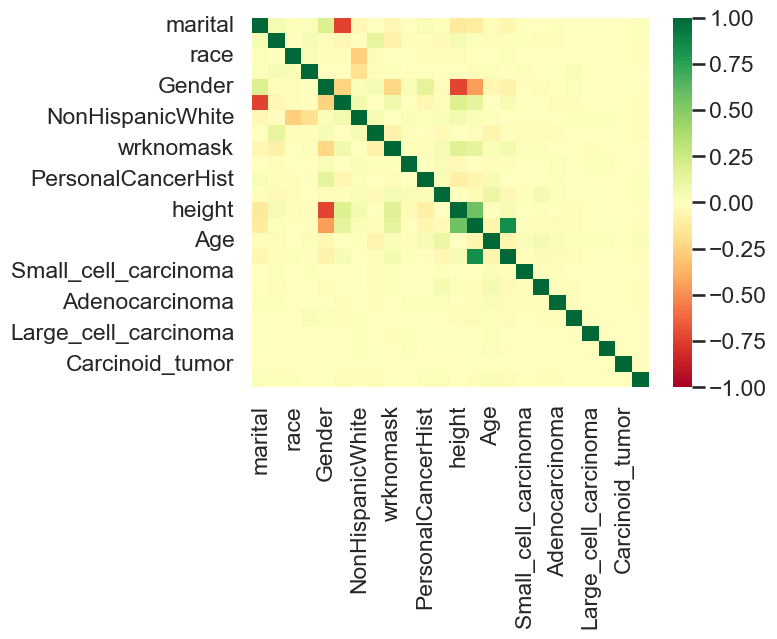

In [29]:
sns.heatmap(sybil_nlst_demos[nlst_democols['cat']['demo'] + nlst_democols['cat']['other'] + nlst_democols['num']['demo'] + nlst_democols['cat']['lungcanc']].corr(), cmap='RdYlGn', vmin=-1, vmax=1)